<img src="https://www.luxonis.com/logo.svg" width="400">

# Training an Instance Segmentation Model from a Roboflow Dataset

## 🌟 Overview
In this tutorial, we'll go through the process of training a custom instance segmentation model using a dataset from Roboflow Universe. We'll find a suitable dataset and import it to LuxonisTrain pipeline. We'll also validate the performance of our model, export it, and make it ready for deployment on a Luxonis device.

## 📜 Table of Contents
- [🛠️ Installation](#️installation)
- [🗃️ Data Preparation](#data-preparation)
- [🏋️‍♂️ Training](#️️training)
    - [⚙️ Configuration](#️configuration)
    - [🦾 Train](#train)
- [✍ Test](#test)
    - [🧠 Infer](#infer)
- [🗂️ Export and Archive](#export-and-archive)
- [🤖 Deploy](#deploy)
- [📷 DepthAI Script](#depthai-script)

<a name="️installation"></a>

## 🛠️ Installation


The main focus of this tutorial is using [`LuxonisTrain`](https://github.com/luxonis/luxonis-train), a user-friendly tool designed to streamline the training of deep learning models, especially for edge devices. We'll also use [`LuxonisML`](https://github.com/luxonis/luxonis-ml) since it provides us with a collection of utility functionality. We will download the dataset from a popular open-source annotated data repostiory - [Roboflow](https://roboflow.com/).

In [2]:
# %pip install -q datasets>=3.1.0 luxonis-train==0.3.8 -U
%pip install -q luxonis-train==0.3.8 -U

Note: you may need to restart the kernel to use updated packages.


<a name ="data-preparation"></a>

## Data Preparation

Find a dataset that best matches your use case on [Roboflow Universe](https://universe.roboflow.com/). For this demo we chose [PCB defects dataset](https://universe.roboflow.com/learn-uzoux/pcb-defect-0i1a7) that has annotated soldering quality for SMD components.

To get the dataset in for training go to `Dataset tab` in the Roboflow project page, select the desired version and copy the URL. From this URL you will need to extract the data in order for the final line to look like: 

    roboflow://<TEAM_NAME>/<DATASET_NAME>/<DATASET_VERSION>/coco

Our URL was: https://universe.roboflow.com/learn-uzoux/pcb-defect-0i1a7 and the end line looks like:

    roboflow://learn-uzoux/pcb-defect-0i1a7/2/coco

You will need this in the following step. 

💡 Tip (Optional): If the original dataset is not good enough for your usecase, you can expand it by uploading your own custom images and annotations using the Roboflow web interface. Follow Roboflow's [official tutorial](https://blog.roboflow.com/getting-started-with-roboflow/) here to get started.

<a name ="️️training"></a>

## 🏋️‍♂️ Training

<a name ="️configuration"></a>

### ⚙️ Configuration

We have prepared the dataset and are almost ready for the actual training. The last step is just to set up our training configuration file. The whole training process in `LuxonisTrain` doesn't require any coding. We advise you to take one of the base configuration files from [here](https://github.com/luxonis/luxonis-train/tree/main/configs) depending on the task, and then edit it to fit your needs.

In our case, since we are training an instance segmentation model, we'll take a [`instance_segmentation_light_model.yaml`](https://github.com/luxonis/luxonis-train/blob/main/configs/instance_segmentation_light_model.yaml) config as a starting point, which downloads pre-trained COCO weights, making it ideal for fine-tuning. There are many parameters that we can change, and we advise you to go through the [`documentation`](https://github.com/luxonis/luxonis-train/blob/main/configs/README.md) to find all of them. In this tutorial, we'll only go through some basic ones to get you started on your journey.

Below is a starting point for our config. As mentioned before, we already made some changes to it, so it works with this tutorial (model name and dataset name change), but feel free to edit it further and make it your own. When you are done editing, you can execute the cell, and the file will be written and ready to use.

Make sure you point the training of the model to your own dataset by changing the parameter `dataset_dir`.

**Note**: In case you don't have enough computing power on your machine, you can either use [Google Colab](https://colab.research.google.com/) (with GPU enabled), or you can try tweaking the training hyperparameters (such as lowering number of epochs or batch size). However, please be aware that bad parametrization can result in worse performance.

In [6]:
%%writefile pcb_defect_segmentation_model_config.yaml
model:
  name: pcb_defects_instance_seg
  predefined_model:
    name: InstanceSegmentationModel
    params:
      variant: light
      loss_params:
        bbox_loss_weight: 60 # Should be 7.5 * accumulate_grad_batches for best results
        class_loss_weight: 4 # Should be 0.5 * accumulate_grad_batches for best results
        dfl_loss_weight: 12 # Should be 1.5 * accumulate_grad_batches for best results

loader:
  params:
    dataset_dir: "roboflow://learn-uzoux/pcb-defect-0i1a7/2/coco" # Change this link to your dataset

trainer:
  precision: "16-mixed"
  preprocessing:
    train_image_size: [384, 512]
    keep_aspect_ratio: true
    normalize:
      active: true
      params:
        mean: [0., 0., 0.]
        std: [1, 1, 1]
    augmentations:
    - name: Rotate
      params:
        limit: 3
        p: 0.5
        border_mode: 0
        value: [0, 0, 0]
    - name: Perspective
      params:
        scale: [0.02, 0.04]
        keep_size: true
        pad_mode: 0
        pad_val: 0
        mask_pad_val: 0
        fit_output: false
        interpolation: 1
        always_apply: false
        p: 0.5
    - name: Affine
      params:
        scale: 1
        translate_percent: 0
        translate_px: null
        shear: 5
        interpolation: 1
        mask_interpolation: 0
        cval: 0
        cval_mask: 0
        mode: 0
        fit_output: false
        keep_ratio: false
        rotate_method: largest_box
        always_apply: false
        p: 0.4
    - name: MotionBlur
      params:
        blur_limit: [2,4]
        p: 0.1
    - name: ToGray
      params:
        p: 0.5
    - name: RandomBrightnessContrast
      params:
        ensure_safe_range: True
        p: 0.3
    - name: GaussNoise
      params:
        std_range: [0.0, 0.05]
        p: 0.1

  batch_size: 8
  epochs: &epochs 200
  n_workers: 4
  validation_interval: 10
  n_log_images: 8
  gradient_clip_val: 10

  callbacks:
    - name: EMACallback
      params:
        decay: 0.9999
        use_dynamic_decay: True
        decay_tau: 2000
    - name: ExportOnTrainEnd
    - name: TestOnTrainEnd
    - name: GradientAccumulationScheduler
      params:
        scheduling: # warmup phase is 3 epochs
          0: 1
          1: 4
          2: 8 # For best results, always accumulate gradients to effectively use 64 batch size

  training_strategy:
    name: "TripleLRSGDStrategy"
    params:
      warmup_epochs: 3
      warmup_bias_lr: 0.0
      warmup_momentum: 0.8
      lr: 0.01
      lre: 0.0001
      momentum: 0.937
      weight_decay: 0.0005
      nesterov: True
      cosine_annealing: False

Overwriting pcb_defect_segmentation_model_config.yaml


<a name ="train"></a>

### 🦾 Train

To start the training, we need to initialize the `LuxonisModel`, pass it the path to the configuration file, and call the `train()` method on it. You will also need to insert your Roboflow API key.

**Note**: LuxonisTrain also supports all these commands through usage of its CLI ([docs here](https://github.com/luxonis/luxonis-train/tree/main?tab=readme-ov-file#-cli)), no code required. We won't use them for tutorial purposes, but feel free to use them when you do it yourself.

In [7]:
# If you are using your private dataset from Roboflow, you must enter your API key
import os
os.environ['ROBOFLOW_API_KEY'] = '<ADD_YOUR_ROBOFLOW_API_KEY_HERE>'

In [ ]:
from luxonis_train import LuxonisModel

config_path = "pcb_defect_segmentation_model_config.yaml"

luxonis_model = LuxonisModel(config_path)
luxonis_model.train()

`LuxonisTrain` has also already implemented automatic tracking of training runs. By default, `Tensorboard` is used, and to look at the losses, metrics, and visualizations during training, we can inspect the logs. If you check the `output` folder, you'll see that every run creates a new directory, and each run also has its training logs in the `./output/tensorboard_logs` where the name of the folder matches the run's name. To make all the subsequent commands work automatically, please set the name of your run below.

In [10]:
RUN_NAME = "<YOUR_RUN_NAME>"

In [ ]:
%load_ext tensorboard
%tensorboard --logdir output/tensorboard_logs # TODO: Change the name of the training run

<a name ="test"></a>

## ✍ Test

Now, we have a trained model that performs well on the validation set. The next step is to check its performance on the testing set, a collection of images we've kept hidden from the model. It should only be used to evaluate whether the model is good objectively. Since this is an instance segmentation task, we use the Mean Average Precision, Mean Average Recall, and F1 Score metrics to check the model performance quantitatively.

If you check out the run directory, you'll see two folders inside: `best_val_metric` and `min_val_loss`. Both have checkpoint files generated during training based on best validation metric performance and minimal validation loss. For evaluation, we'll want to use one of these checkpoints; we recommend that you use one that has the lowest validation loss.

In [13]:
weights = luxonis_model.get_min_loss_checkpoint_path() # gets checkpoint where validation loss was the lowest
# weights = luxonis_model.get_best_metric_checkpoint_path() # gets checkpoint where validation metric was the highest

metrics = luxonis_model.test(view="test", weights=weights)

WARNING  Key `nodes.EfficientRep.repvgg_encoder.rbr_dense.0.weight` from checkpoint not    ]8;id=828998;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=215481;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.repvgg_encoder.rbr_dense.1.weight` from checkpoint not    ]8;id=501872;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=455317;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.repvgg_encoder.rbr_dense.1.bias` from checkpoint not      ]8;id=773175;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=73503;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.repvgg_encoder.rbr_dense.1.running_mean` from checkpoint  ]8;id=651114;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=275252;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.repvgg_encoder.rbr_dense.1.running_var` from checkpoint   ]8;id=318261;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=177979;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.repvgg_encoder.rbr_dense.1.num_batches_tracked` from      ]8;id=189177;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=665381;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.repvgg_encoder.rbr_1x1.0.weight` from checkpoint not      ]8;id=125279;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=202909;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.repvgg_encoder.rbr_1x1.1.weight` from checkpoint not      ]8;id=613703;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=241267;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.repvgg_encoder.rbr_1x1.1.bias` from checkpoint not found  ]8;id=204208;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=538278;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         in model state dict.                                                                                      

WARNING  Key `nodes.EfficientRep.repvgg_encoder.rbr_1x1.1.running_mean` from checkpoint    ]8;id=707339;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=784989;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.repvgg_encoder.rbr_1x1.1.running_var` from checkpoint not ]8;id=692680;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=363954;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.repvgg_encoder.rbr_1x1.1.num_batches_tracked` from        ]8;id=117929;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=34027;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.0.0.rbr_dense.0.weight` from checkpoint not found  ]8;id=243959;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=43666;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         in model state dict.                                                                                      

WARNING  Key `nodes.EfficientRep.blocks.0.0.rbr_dense.1.weight` from checkpoint not found  ]8;id=654484;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=894674;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         in model state dict.                                                                                      

WARNING  Key `nodes.EfficientRep.blocks.0.0.rbr_dense.1.bias` from checkpoint not found in ]8;id=668980;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=489905;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         model state dict.                                                                                         

WARNING  Key `nodes.EfficientRep.blocks.0.0.rbr_dense.1.running_mean` from checkpoint not  ]8;id=913804;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=15668;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.0.0.rbr_dense.1.running_var` from checkpoint not   ]8;id=783906;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=499330;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.0.0.rbr_dense.1.num_batches_tracked` from          ]8;id=182315;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=811359;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.0.0.rbr_1x1.0.weight` from checkpoint not found in ]8;id=281801;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=301485;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         model state dict.                                                                                         

WARNING  Key `nodes.EfficientRep.blocks.0.0.rbr_1x1.1.weight` from checkpoint not found in ]8;id=760636;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=318704;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         model state dict.                                                                                         

WARNING  Key `nodes.EfficientRep.blocks.0.0.rbr_1x1.1.bias` from checkpoint not found in   ]8;id=596227;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=521047;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         model state dict.                                                                                         

WARNING  Key `nodes.EfficientRep.blocks.0.0.rbr_1x1.1.running_mean` from checkpoint not    ]8;id=998181;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=547738;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.0.0.rbr_1x1.1.running_var` from checkpoint not     ]8;id=731678;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=206302;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.0.0.rbr_1x1.1.num_batches_tracked` from checkpoint ]8;id=277281;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=759504;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.0.rbr_identity.weight` from checkpoint  ]8;id=515686;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=118038;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.0.rbr_identity.bias` from checkpoint    ]8;id=870112;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=176768;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.0.rbr_identity.running_mean` from       ]8;id=23594;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=769453;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.0.rbr_identity.running_var` from        ]8;id=84860;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=171809;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.0.rbr_identity.num_batches_tracked`     ]8;id=66563;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=242515;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.0.rbr_dense.0.weight` from checkpoint   ]8;id=586786;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=952936;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.0.rbr_dense.1.weight` from checkpoint   ]8;id=37268;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=792035;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.0.rbr_dense.1.bias` from checkpoint not ]8;id=633659;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=74144;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.0.rbr_dense.1.running_mean` from        ]8;id=216221;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=672641;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.0.rbr_dense.1.running_var` from         ]8;id=967787;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=534739;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.0.rbr_dense.1.num_batches_tracked` from ]8;id=584289;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=238472;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.0.rbr_1x1.0.weight` from checkpoint not ]8;id=703798;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=36885;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.0.rbr_1x1.1.weight` from checkpoint not ]8;id=927203;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=667831;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.0.rbr_1x1.1.bias` from checkpoint not   ]8;id=646179;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=930449;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.0.rbr_1x1.1.running_mean` from          ]8;id=552924;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=543085;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.0.rbr_1x1.1.running_var` from           ]8;id=23235;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=948821;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.0.rbr_1x1.1.num_batches_tracked` from   ]8;id=938304;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=317453;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.1.rbr_identity.weight` from checkpoint  ]8;id=341543;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=983388;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.1.rbr_identity.bias` from checkpoint    ]8;id=222821;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=955300;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.1.rbr_identity.running_mean` from       ]8;id=644318;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=984384;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.1.rbr_identity.running_var` from        ]8;id=377677;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=817742;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.1.rbr_identity.num_batches_tracked`     ]8;id=599328;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=194732;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.1.rbr_dense.0.weight` from checkpoint   ]8;id=692577;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=954529;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.1.rbr_dense.1.weight` from checkpoint   ]8;id=914358;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=149944;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.1.rbr_dense.1.bias` from checkpoint not ]8;id=5208;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=73347;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.1.rbr_dense.1.running_mean` from        ]8;id=769227;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=344608;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.1.rbr_dense.1.running_var` from         ]8;id=459896;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=390128;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.1.rbr_dense.1.num_batches_tracked` from ]8;id=795219;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=811940;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.1.rbr_1x1.0.weight` from checkpoint not ]8;id=610603;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=193138;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.1.rbr_1x1.1.weight` from checkpoint not ]8;id=77283;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=302593;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.1.rbr_1x1.1.bias` from checkpoint not   ]8;id=344754;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=510431;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.1.rbr_1x1.1.running_mean` from          ]8;id=267530;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=736691;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.1.rbr_1x1.1.running_var` from           ]8;id=689420;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=532496;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.1.rbr_1x1.1.num_batches_tracked` from   ]8;id=96135;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=554457;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.1.0.rbr_dense.0.weight` from checkpoint not found  ]8;id=142880;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=441041;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         in model state dict.                                                                                      

WARNING  Key `nodes.EfficientRep.blocks.1.0.rbr_dense.1.weight` from checkpoint not found  ]8;id=184875;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=750015;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         in model state dict.                                                                                      

WARNING  Key `nodes.EfficientRep.blocks.1.0.rbr_dense.1.bias` from checkpoint not found in ]8;id=839690;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=931882;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         model state dict.                                                                                         

WARNING  Key `nodes.EfficientRep.blocks.1.0.rbr_dense.1.running_mean` from checkpoint not  ]8;id=710273;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=788916;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.1.0.rbr_dense.1.running_var` from checkpoint not   ]8;id=28370;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=755789;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.1.0.rbr_dense.1.num_batches_tracked` from          ]8;id=712420;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=146494;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.1.0.rbr_1x1.0.weight` from checkpoint not found in ]8;id=646112;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=3353;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         model state dict.                                                                                         

WARNING  Key `nodes.EfficientRep.blocks.1.0.rbr_1x1.1.weight` from checkpoint not found in ]8;id=757308;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=951201;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         model state dict.                                                                                         

WARNING  Key `nodes.EfficientRep.blocks.1.0.rbr_1x1.1.bias` from checkpoint not found in   ]8;id=941635;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=296752;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         model state dict.                                                                                         

WARNING  Key `nodes.EfficientRep.blocks.1.0.rbr_1x1.1.running_mean` from checkpoint not    ]8;id=903915;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=573933;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.1.0.rbr_1x1.1.running_var` from checkpoint not     ]8;id=234928;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=431570;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.1.0.rbr_1x1.1.num_batches_tracked` from checkpoint ]8;id=607643;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=46615;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.0.rbr_identity.weight` from checkpoint  ]8;id=723147;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=62149;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.0.rbr_identity.bias` from checkpoint    ]8;id=269518;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=384926;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.0.rbr_identity.running_mean` from       ]8;id=394797;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=796086;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.0.rbr_identity.running_var` from        ]8;id=263975;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=38878;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.0.rbr_identity.num_batches_tracked`     ]8;id=870508;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=544597;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.0.rbr_dense.0.weight` from checkpoint   ]8;id=228729;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=977132;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.0.rbr_dense.1.weight` from checkpoint   ]8;id=84623;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=636699;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.0.rbr_dense.1.bias` from checkpoint not ]8;id=431326;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=411088;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.0.rbr_dense.1.running_mean` from        ]8;id=800148;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=146419;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.0.rbr_dense.1.running_var` from         ]8;id=218541;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=18330;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.0.rbr_dense.1.num_batches_tracked` from ]8;id=96006;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=329560;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.0.rbr_1x1.0.weight` from checkpoint not ]8;id=751871;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=243780;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.0.rbr_1x1.1.weight` from checkpoint not ]8;id=919141;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=609488;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.0.rbr_1x1.1.bias` from checkpoint not   ]8;id=657961;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=903991;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.0.rbr_1x1.1.running_mean` from          ]8;id=994979;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=44979;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.0.rbr_1x1.1.running_var` from           ]8;id=844192;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=178021;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.0.rbr_1x1.1.num_batches_tracked` from   ]8;id=840232;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=823696;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.1.rbr_identity.weight` from checkpoint  ]8;id=263059;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=609898;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.1.rbr_identity.bias` from checkpoint    ]8;id=936224;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=561781;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.1.rbr_identity.running_mean` from       ]8;id=984006;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=664847;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.1.rbr_identity.running_var` from        ]8;id=663070;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=250962;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.1.rbr_identity.num_batches_tracked`     ]8;id=791536;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=955741;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.1.rbr_dense.0.weight` from checkpoint   ]8;id=196621;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=606679;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.1.rbr_dense.1.weight` from checkpoint   ]8;id=92595;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=283515;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.1.rbr_dense.1.bias` from checkpoint not ]8;id=932552;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=95566;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.1.rbr_dense.1.running_mean` from        ]8;id=723948;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=650301;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.1.rbr_dense.1.running_var` from         ]8;id=136105;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=46971;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.1.rbr_dense.1.num_batches_tracked` from ]8;id=730161;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=269643;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.1.rbr_1x1.0.weight` from checkpoint not ]8;id=469793;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=963428;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.1.rbr_1x1.1.weight` from checkpoint not ]8;id=397895;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=713597;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.1.rbr_1x1.1.bias` from checkpoint not   ]8;id=775983;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=435534;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.1.rbr_1x1.1.running_mean` from          ]8;id=845127;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=431725;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.1.rbr_1x1.1.running_var` from           ]8;id=414798;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=265802;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.1.rbr_1x1.1.num_batches_tracked` from   ]8;id=107648;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=949455;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.2.rbr_identity.weight` from checkpoint  ]8;id=780451;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=564722;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.2.rbr_identity.bias` from checkpoint    ]8;id=54947;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=457277;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.2.rbr_identity.running_mean` from       ]8;id=795511;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=262109;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.2.rbr_identity.running_var` from        ]8;id=511740;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=298758;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.2.rbr_identity.num_batches_tracked`     ]8;id=575483;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=325084;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.2.rbr_dense.0.weight` from checkpoint   ]8;id=14631;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=675393;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.2.rbr_dense.1.weight` from checkpoint   ]8;id=338497;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=710117;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.2.rbr_dense.1.bias` from checkpoint not ]8;id=954948;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=170530;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.2.rbr_dense.1.running_mean` from        ]8;id=802152;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=206520;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.2.rbr_dense.1.running_var` from         ]8;id=602235;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=918627;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.2.rbr_dense.1.num_batches_tracked` from ]8;id=443088;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=875918;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.2.rbr_1x1.0.weight` from checkpoint not ]8;id=929790;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=46243;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.2.rbr_1x1.1.weight` from checkpoint not ]8;id=566959;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=32154;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.2.rbr_1x1.1.bias` from checkpoint not   ]8;id=746346;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=964993;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.2.rbr_1x1.1.running_mean` from          ]8;id=91655;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=26171;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.2.rbr_1x1.1.running_var` from           ]8;id=941912;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=489328;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.2.rbr_1x1.1.num_batches_tracked` from   ]8;id=587424;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=691421;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.3.rbr_identity.weight` from checkpoint  ]8;id=595119;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=479191;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.3.rbr_identity.bias` from checkpoint    ]8;id=940119;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=787367;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.3.rbr_identity.running_mean` from       ]8;id=652929;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=420195;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.3.rbr_identity.running_var` from        ]8;id=866912;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=67820;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.3.rbr_identity.num_batches_tracked`     ]8;id=678322;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=630804;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.3.rbr_dense.0.weight` from checkpoint   ]8;id=260602;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=873392;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.3.rbr_dense.1.weight` from checkpoint   ]8;id=838875;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=615010;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.3.rbr_dense.1.bias` from checkpoint not ]8;id=155555;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=359952;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.3.rbr_dense.1.running_mean` from        ]8;id=488866;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=61950;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.3.rbr_dense.1.running_var` from         ]8;id=800704;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=759674;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.3.rbr_dense.1.num_batches_tracked` from ]8;id=416996;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=326121;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.3.rbr_1x1.0.weight` from checkpoint not ]8;id=402665;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=394768;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.3.rbr_1x1.1.weight` from checkpoint not ]8;id=442750;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=415298;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.3.rbr_1x1.1.bias` from checkpoint not   ]8;id=243850;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=971811;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.3.rbr_1x1.1.running_mean` from          ]8;id=323324;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=404498;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.3.rbr_1x1.1.running_var` from           ]8;id=460139;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=461306;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.3.rbr_1x1.1.num_batches_tracked` from   ]8;id=731685;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=973083;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.0.rbr_dense.0.weight` from checkpoint not found  ]8;id=151119;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=710067;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         in model state dict.                                                                                      

WARNING  Key `nodes.EfficientRep.blocks.2.0.rbr_dense.1.weight` from checkpoint not found  ]8;id=721305;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=664637;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         in model state dict.                                                                                      

WARNING  Key `nodes.EfficientRep.blocks.2.0.rbr_dense.1.bias` from checkpoint not found in ]8;id=14227;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=233013;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         model state dict.                                                                                         

WARNING  Key `nodes.EfficientRep.blocks.2.0.rbr_dense.1.running_mean` from checkpoint not  ]8;id=49890;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=795230;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.2.0.rbr_dense.1.running_var` from checkpoint not   ]8;id=593093;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=923685;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.2.0.rbr_dense.1.num_batches_tracked` from          ]8;id=339370;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=412453;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.0.rbr_1x1.0.weight` from checkpoint not found in ]8;id=204529;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=872139;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         model state dict.                                                                                         

WARNING  Key `nodes.EfficientRep.blocks.2.0.rbr_1x1.1.weight` from checkpoint not found in ]8;id=242172;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=889942;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         model state dict.                                                                                         

WARNING  Key `nodes.EfficientRep.blocks.2.0.rbr_1x1.1.bias` from checkpoint not found in   ]8;id=930649;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=871021;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         model state dict.                                                                                         

WARNING  Key `nodes.EfficientRep.blocks.2.0.rbr_1x1.1.running_mean` from checkpoint not    ]8;id=936291;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=496676;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.2.0.rbr_1x1.1.running_var` from checkpoint not     ]8;id=448268;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=4479;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.2.0.rbr_1x1.1.num_batches_tracked` from checkpoint ]8;id=354488;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=557307;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.0.rbr_identity.weight` from checkpoint  ]8;id=976275;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=516657;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.0.rbr_identity.bias` from checkpoint    ]8;id=303251;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=738722;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.0.rbr_identity.running_mean` from       ]8;id=769014;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=95589;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.0.rbr_identity.running_var` from        ]8;id=118678;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=876484;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.0.rbr_identity.num_batches_tracked`     ]8;id=749323;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=750066;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.0.rbr_dense.0.weight` from checkpoint   ]8;id=904164;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=927127;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.0.rbr_dense.1.weight` from checkpoint   ]8;id=56386;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=703054;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.0.rbr_dense.1.bias` from checkpoint not ]8;id=722083;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=927348;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.0.rbr_dense.1.running_mean` from        ]8;id=740798;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=821865;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.0.rbr_dense.1.running_var` from         ]8;id=107975;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=762931;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.0.rbr_dense.1.num_batches_tracked` from ]8;id=7665;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=703912;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.0.rbr_1x1.0.weight` from checkpoint not ]8;id=134401;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=990544;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.0.rbr_1x1.1.weight` from checkpoint not ]8;id=771562;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=79065;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.0.rbr_1x1.1.bias` from checkpoint not   ]8;id=830584;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=292162;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.0.rbr_1x1.1.running_mean` from          ]8;id=29318;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=771456;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.0.rbr_1x1.1.running_var` from           ]8;id=18998;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=354934;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.0.rbr_1x1.1.num_batches_tracked` from   ]8;id=1950;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=11242;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.1.rbr_identity.weight` from checkpoint  ]8;id=759580;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=382759;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.1.rbr_identity.bias` from checkpoint    ]8;id=418000;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=177415;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.1.rbr_identity.running_mean` from       ]8;id=149217;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=783048;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.1.rbr_identity.running_var` from        ]8;id=630391;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=131219;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.1.rbr_identity.num_batches_tracked`     ]8;id=246064;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=347703;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.1.rbr_dense.0.weight` from checkpoint   ]8;id=961866;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=803660;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.1.rbr_dense.1.weight` from checkpoint   ]8;id=96305;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=691562;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.1.rbr_dense.1.bias` from checkpoint not ]8;id=343111;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=115908;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.1.rbr_dense.1.running_mean` from        ]8;id=582365;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=759430;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.1.rbr_dense.1.running_var` from         ]8;id=948356;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=231207;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.1.rbr_dense.1.num_batches_tracked` from ]8;id=533549;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=236764;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.1.rbr_1x1.0.weight` from checkpoint not ]8;id=58531;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=84171;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.1.rbr_1x1.1.weight` from checkpoint not ]8;id=905334;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=569798;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.1.rbr_1x1.1.bias` from checkpoint not   ]8;id=172268;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=596300;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.1.rbr_1x1.1.running_mean` from          ]8;id=569530;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=724049;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.1.rbr_1x1.1.running_var` from           ]8;id=631804;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=391541;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.1.rbr_1x1.1.num_batches_tracked` from   ]8;id=913131;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=56001;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.2.rbr_identity.weight` from checkpoint  ]8;id=625086;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=834789;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.2.rbr_identity.bias` from checkpoint    ]8;id=559116;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=877731;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.2.rbr_identity.running_mean` from       ]8;id=909084;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=743981;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.2.rbr_identity.running_var` from        ]8;id=119878;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=776469;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.2.rbr_identity.num_batches_tracked`     ]8;id=155537;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=50192;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.2.rbr_dense.0.weight` from checkpoint   ]8;id=90753;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=545552;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.2.rbr_dense.1.weight` from checkpoint   ]8;id=7414;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=179318;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.2.rbr_dense.1.bias` from checkpoint not ]8;id=124368;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=305060;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.2.rbr_dense.1.running_mean` from        ]8;id=264270;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=253275;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.2.rbr_dense.1.running_var` from         ]8;id=719016;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=579340;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.2.rbr_dense.1.num_batches_tracked` from ]8;id=294334;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=665016;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.2.rbr_1x1.0.weight` from checkpoint not ]8;id=543493;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=859922;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.2.rbr_1x1.1.weight` from checkpoint not ]8;id=308873;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=511341;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.2.rbr_1x1.1.bias` from checkpoint not   ]8;id=582208;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=835588;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.2.rbr_1x1.1.running_mean` from          ]8;id=268455;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=570809;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.2.rbr_1x1.1.running_var` from           ]8;id=59275;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=40408;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.2.rbr_1x1.1.num_batches_tracked` from   ]8;id=901963;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=671978;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.3.rbr_identity.weight` from checkpoint  ]8;id=249863;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=44700;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.3.rbr_identity.bias` from checkpoint    ]8;id=44705;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=795129;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.3.rbr_identity.running_mean` from       ]8;id=685596;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=938131;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.3.rbr_identity.running_var` from        ]8;id=388109;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=738979;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.3.rbr_identity.num_batches_tracked`     ]8;id=469479;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=57942;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.3.rbr_dense.0.weight` from checkpoint   ]8;id=222662;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=53877;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.3.rbr_dense.1.weight` from checkpoint   ]8;id=317634;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=591621;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.3.rbr_dense.1.bias` from checkpoint not ]8;id=637675;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=446149;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.3.rbr_dense.1.running_mean` from        ]8;id=932832;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=956783;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.3.rbr_dense.1.running_var` from         ]8;id=465152;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=347803;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.3.rbr_dense.1.num_batches_tracked` from ]8;id=509583;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=618844;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.3.rbr_1x1.0.weight` from checkpoint not ]8;id=217939;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=301760;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.3.rbr_1x1.1.weight` from checkpoint not ]8;id=891702;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=283968;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.3.rbr_1x1.1.bias` from checkpoint not   ]8;id=370250;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=706991;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.3.rbr_1x1.1.running_mean` from          ]8;id=498205;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=855942;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.3.rbr_1x1.1.running_var` from           ]8;id=896964;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=727595;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.3.rbr_1x1.1.num_batches_tracked` from   ]8;id=114918;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=214938;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.4.rbr_identity.weight` from checkpoint  ]8;id=293734;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=313800;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.4.rbr_identity.bias` from checkpoint    ]8;id=741895;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=536026;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.4.rbr_identity.running_mean` from       ]8;id=106005;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=190507;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.4.rbr_identity.running_var` from        ]8;id=675803;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=562284;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.4.rbr_identity.num_batches_tracked`     ]8;id=174362;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=632559;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.4.rbr_dense.0.weight` from checkpoint   ]8;id=907075;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=342738;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.4.rbr_dense.1.weight` from checkpoint   ]8;id=100160;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=862338;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.4.rbr_dense.1.bias` from checkpoint not ]8;id=647037;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=725997;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.4.rbr_dense.1.running_mean` from        ]8;id=730299;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=695218;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.4.rbr_dense.1.running_var` from         ]8;id=819235;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=225480;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.4.rbr_dense.1.num_batches_tracked` from ]8;id=615280;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=408246;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.4.rbr_1x1.0.weight` from checkpoint not ]8;id=818597;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=247305;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.4.rbr_1x1.1.weight` from checkpoint not ]8;id=609367;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=924061;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.4.rbr_1x1.1.bias` from checkpoint not   ]8;id=379746;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=238190;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.4.rbr_1x1.1.running_mean` from          ]8;id=783923;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=839662;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.4.rbr_1x1.1.running_var` from           ]8;id=942273;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=965556;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.4.rbr_1x1.1.num_batches_tracked` from   ]8;id=603137;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=865081;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.5.rbr_identity.weight` from checkpoint  ]8;id=291514;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=236659;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.5.rbr_identity.bias` from checkpoint    ]8;id=486732;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=693918;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.5.rbr_identity.running_mean` from       ]8;id=6870;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=739665;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.5.rbr_identity.running_var` from        ]8;id=391759;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=669882;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.5.rbr_identity.num_batches_tracked`     ]8;id=91935;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=437418;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.5.rbr_dense.0.weight` from checkpoint   ]8;id=938989;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=563317;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.5.rbr_dense.1.weight` from checkpoint   ]8;id=725079;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=873395;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.5.rbr_dense.1.bias` from checkpoint not ]8;id=389215;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=20735;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.5.rbr_dense.1.running_mean` from        ]8;id=826797;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=612658;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.5.rbr_dense.1.running_var` from         ]8;id=88421;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=214986;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.5.rbr_dense.1.num_batches_tracked` from ]8;id=178330;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=928800;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.5.rbr_1x1.0.weight` from checkpoint not ]8;id=483460;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=183672;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.5.rbr_1x1.1.weight` from checkpoint not ]8;id=910010;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=978816;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.5.rbr_1x1.1.bias` from checkpoint not   ]8;id=295081;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=288808;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.5.rbr_1x1.1.running_mean` from          ]8;id=630860;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=367097;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.5.rbr_1x1.1.running_var` from           ]8;id=65327;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=737567;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.5.rbr_1x1.1.num_batches_tracked` from   ]8;id=829323;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=201066;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.3.0.rbr_dense.0.weight` from checkpoint not found  ]8;id=370758;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=190422;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         in model state dict.                                                                                      

WARNING  Key `nodes.EfficientRep.blocks.3.0.rbr_dense.1.weight` from checkpoint not found  ]8;id=702773;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=361761;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         in model state dict.                                                                                      

WARNING  Key `nodes.EfficientRep.blocks.3.0.rbr_dense.1.bias` from checkpoint not found in ]8;id=850617;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=717938;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         model state dict.                                                                                         

WARNING  Key `nodes.EfficientRep.blocks.3.0.rbr_dense.1.running_mean` from checkpoint not  ]8;id=748029;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=648978;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.3.0.rbr_dense.1.running_var` from checkpoint not   ]8;id=286929;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=119464;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.3.0.rbr_dense.1.num_batches_tracked` from          ]8;id=371818;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=820644;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.3.0.rbr_1x1.0.weight` from checkpoint not found in ]8;id=621619;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=494898;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         model state dict.                                                                                         

WARNING  Key `nodes.EfficientRep.blocks.3.0.rbr_1x1.1.weight` from checkpoint not found in ]8;id=548622;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=86994;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         model state dict.                                                                                         

WARNING  Key `nodes.EfficientRep.blocks.3.0.rbr_1x1.1.bias` from checkpoint not found in   ]8;id=46166;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=611999;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         model state dict.                                                                                         

WARNING  Key `nodes.EfficientRep.blocks.3.0.rbr_1x1.1.running_mean` from checkpoint not    ]8;id=797051;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=297813;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.3.0.rbr_1x1.1.running_var` from checkpoint not     ]8;id=824935;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=551090;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.3.0.rbr_1x1.1.num_batches_tracked` from checkpoint ]8;id=994601;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=853438;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.0.rbr_identity.weight` from checkpoint  ]8;id=471729;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=686301;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.0.rbr_identity.bias` from checkpoint    ]8;id=144269;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=756710;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.0.rbr_identity.running_mean` from       ]8;id=182938;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=106457;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.0.rbr_identity.running_var` from        ]8;id=156334;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=782646;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.0.rbr_identity.num_batches_tracked`     ]8;id=654332;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=140280;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.0.rbr_dense.0.weight` from checkpoint   ]8;id=519869;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=591600;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.0.rbr_dense.1.weight` from checkpoint   ]8;id=437994;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=292760;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.0.rbr_dense.1.bias` from checkpoint not ]8;id=112970;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=618266;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.0.rbr_dense.1.running_mean` from        ]8;id=258141;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=58453;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.0.rbr_dense.1.running_var` from         ]8;id=746067;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=842551;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.0.rbr_dense.1.num_batches_tracked` from ]8;id=10067;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=171057;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.0.rbr_1x1.0.weight` from checkpoint not ]8;id=13212;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=182798;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.0.rbr_1x1.1.weight` from checkpoint not ]8;id=532577;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=729890;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.0.rbr_1x1.1.bias` from checkpoint not   ]8;id=721657;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=493035;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.0.rbr_1x1.1.running_mean` from          ]8;id=726685;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=450822;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.0.rbr_1x1.1.running_var` from           ]8;id=308140;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=128037;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.0.rbr_1x1.1.num_batches_tracked` from   ]8;id=933598;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=763894;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.1.rbr_identity.weight` from checkpoint  ]8;id=190179;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=60034;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.1.rbr_identity.bias` from checkpoint    ]8;id=754621;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=556352;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.1.rbr_identity.running_mean` from       ]8;id=810593;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=928220;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.1.rbr_identity.running_var` from        ]8;id=546522;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=902480;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.1.rbr_identity.num_batches_tracked`     ]8;id=657294;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=813636;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.1.rbr_dense.0.weight` from checkpoint   ]8;id=557010;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=678957;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.1.rbr_dense.1.weight` from checkpoint   ]8;id=367941;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=185496;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         not found in model state dict.                                                                            

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.1.rbr_dense.1.bias` from checkpoint not ]8;id=456704;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=438144;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.1.rbr_dense.1.running_mean` from        ]8;id=38906;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=455141;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.1.rbr_dense.1.running_var` from         ]8;id=770406;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=183830;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.1.rbr_dense.1.num_batches_tracked` from ]8;id=803335;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=121940;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.1.rbr_1x1.0.weight` from checkpoint not ]8;id=730920;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=805030;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.1.rbr_1x1.1.weight` from checkpoint not ]8;id=356745;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=280214;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.1.rbr_1x1.1.bias` from checkpoint not   ]8;id=176057;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=233617;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         found in model state dict.                                                                                

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.1.rbr_1x1.1.running_mean` from          ]8;id=582924;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=281606;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.1.rbr_1x1.1.running_var` from           ]8;id=529651;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=807095;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.1.rbr_1x1.1.num_batches_tracked` from   ]8;id=570830;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=431098;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.0.rbr_dense.0.weight` from ]8;id=101410;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=231378;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.0.rbr_dense.1.weight` from ]8;id=166641;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=440094;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.0.rbr_dense.1.bias` from   ]8;id=869531;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=284925;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key                                                                               ]8;id=345876;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=149461;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.0.rbr_dense.1.running_mean`                            
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.0.rbr_dense.1.running_var` ]8;id=325598;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=329474;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=198678;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=103264;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.0.rbr_dense.1.num_batches_trac                         
         ked` from checkpoint not found in model state dict.                                                       

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.0.rbr_1x1.0.weight` from   ]8;id=874349;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=459801;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.0.rbr_1x1.1.weight` from   ]8;id=89137;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=748187;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.0.rbr_1x1.1.bias` from     ]8;id=228900;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=827232;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.0.rbr_1x1.1.running_mean`  ]8;id=632756;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=531041;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.0.rbr_1x1.1.running_var`   ]8;id=997298;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=664778;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=327769;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=482667;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.0.rbr_1x1.1.num_batches_tracke                         
         d` from checkpoint not found in model state dict.                                                         

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.1.rbr_identity.weight`     ]8;id=934139;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=32900;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.1.rbr_identity.bias` from  ]8;id=10654;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=337441;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key                                                                               ]8;id=285089;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=791252;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.1.rbr_identity.running_mean`                           
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=162213;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=501566;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.1.rbr_identity.running_var`                            
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=829974;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=600826;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.1.rbr_identity.num_batches_tra                         
         cked` from checkpoint not found in model state dict.                                                      

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.1.rbr_dense.0.weight` from ]8;id=403737;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=711513;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.1.rbr_dense.1.weight` from ]8;id=53829;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=816249;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.1.rbr_dense.1.bias` from   ]8;id=828028;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=449122;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key                                                                               ]8;id=607159;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=653359;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.1.rbr_dense.1.running_mean`                            
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.1.rbr_dense.1.running_var` ]8;id=893400;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=245660;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=187776;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=352176;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.1.rbr_dense.1.num_batches_trac                         
         ked` from checkpoint not found in model state dict.                                                       

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.1.rbr_1x1.0.weight` from   ]8;id=873790;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=487815;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.1.rbr_1x1.1.weight` from   ]8;id=427529;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=777879;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.1.rbr_1x1.1.bias` from     ]8;id=18938;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=324114;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.1.rbr_1x1.1.running_mean`  ]8;id=636173;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=816593;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.1.rbr_1x1.1.running_var`   ]8;id=75029;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=333426;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=314737;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=156935;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.1.rbr_1x1.1.num_batches_tracke                         
         d` from checkpoint not found in model state dict.                                                         

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.2.rbr_identity.weight`     ]8;id=704858;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=307474;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.2.rbr_identity.bias` from  ]8;id=994105;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=276104;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key                                                                               ]8;id=294972;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=172541;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.2.rbr_identity.running_mean`                           
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=652034;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=922767;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.2.rbr_identity.running_var`                            
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=975430;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=160270;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.2.rbr_identity.num_batches_tra                         
         cked` from checkpoint not found in model state dict.                                                      

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.2.rbr_dense.0.weight` from ]8;id=575987;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=713744;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.2.rbr_dense.1.weight` from ]8;id=688026;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=648257;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.2.rbr_dense.1.bias` from   ]8;id=752870;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=114995;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key                                                                               ]8;id=283978;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=527341;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.2.rbr_dense.1.running_mean`                            
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.2.rbr_dense.1.running_var` ]8;id=441080;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=284856;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=462933;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=294001;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.2.rbr_dense.1.num_batches_trac                         
         ked` from checkpoint not found in model state dict.                                                       

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.2.rbr_1x1.0.weight` from   ]8;id=745103;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=594169;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.2.rbr_1x1.1.weight` from   ]8;id=477811;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=730900;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.2.rbr_1x1.1.bias` from     ]8;id=188125;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=475064;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.2.rbr_1x1.1.running_mean`  ]8;id=980876;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=972492;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.2.rbr_1x1.1.running_var`   ]8;id=329995;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=877534;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=290382;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=565186;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.2.rbr_1x1.1.num_batches_tracke                         
         d` from checkpoint not found in model state dict.                                                         

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.3.rbr_identity.weight`     ]8;id=988084;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=808402;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.3.rbr_identity.bias` from  ]8;id=735490;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=728323;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key                                                                               ]8;id=944666;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=581471;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.3.rbr_identity.running_mean`                           
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=700835;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=378522;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.3.rbr_identity.running_var`                            
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=356054;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=224336;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.3.rbr_identity.num_batches_tra                         
         cked` from checkpoint not found in model state dict.                                                      

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.3.rbr_dense.0.weight` from ]8;id=392933;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=216603;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.3.rbr_dense.1.weight` from ]8;id=906898;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=200111;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.3.rbr_dense.1.bias` from   ]8;id=547076;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=422017;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key                                                                               ]8;id=777318;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=725820;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.3.rbr_dense.1.running_mean`                            
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.3.rbr_dense.1.running_var` ]8;id=696433;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=942247;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=969662;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=725515;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.3.rbr_dense.1.num_batches_trac                         
         ked` from checkpoint not found in model state dict.                                                       

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.3.rbr_1x1.0.weight` from   ]8;id=216400;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=390415;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.3.rbr_1x1.1.weight` from   ]8;id=934918;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=552216;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.3.rbr_1x1.1.bias` from     ]8;id=580449;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=454165;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.3.rbr_1x1.1.running_mean`  ]8;id=832873;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=585483;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.3.rbr_1x1.1.running_var`   ]8;id=902449;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=405543;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=571267;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=399751;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.3.rbr_1x1.1.num_batches_tracke                         
         d` from checkpoint not found in model state dict.                                                         

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.0.rbr_dense.0.weight` from ]8;id=237705;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=997013;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.0.rbr_dense.1.weight` from ]8;id=485928;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=718392;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.0.rbr_dense.1.bias` from   ]8;id=152685;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=691516;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key                                                                               ]8;id=212501;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=544706;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.0.rbr_dense.1.running_mean`                            
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.0.rbr_dense.1.running_var` ]8;id=439083;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=370189;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=544946;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=757255;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.0.rbr_dense.1.num_batches_trac                         
         ked` from checkpoint not found in model state dict.                                                       

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.0.rbr_1x1.0.weight` from   ]8;id=974056;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=964400;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.0.rbr_1x1.1.weight` from   ]8;id=380927;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=151959;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.0.rbr_1x1.1.bias` from     ]8;id=196325;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=484172;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.0.rbr_1x1.1.running_mean`  ]8;id=88587;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=938837;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.0.rbr_1x1.1.running_var`   ]8;id=458582;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=47633;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=594850;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=176210;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.0.rbr_1x1.1.num_batches_tracke                         
         d` from checkpoint not found in model state dict.                                                         

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.1.rbr_identity.weight`     ]8;id=913175;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=830752;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.1.rbr_identity.bias` from  ]8;id=568614;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=460370;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key                                                                               ]8;id=46811;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=700594;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.1.rbr_identity.running_mean`                           
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=660202;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=520667;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.1.rbr_identity.running_var`                            
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=59227;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=298085;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.1.rbr_identity.num_batches_tra                         
         cked` from checkpoint not found in model state dict.                                                      

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.1.rbr_dense.0.weight` from ]8;id=100705;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=595567;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.1.rbr_dense.1.weight` from ]8;id=960790;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=532467;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.1.rbr_dense.1.bias` from   ]8;id=704349;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=467788;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key                                                                               ]8;id=845569;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=300443;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.1.rbr_dense.1.running_mean`                            
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.1.rbr_dense.1.running_var` ]8;id=96654;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=645923;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=354131;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=891107;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.1.rbr_dense.1.num_batches_trac                         
         ked` from checkpoint not found in model state dict.                                                       

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.1.rbr_1x1.0.weight` from   ]8;id=934713;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=97273;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.1.rbr_1x1.1.weight` from   ]8;id=641005;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=351851;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.1.rbr_1x1.1.bias` from     ]8;id=524995;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=88829;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.1.rbr_1x1.1.running_mean`  ]8;id=404065;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=567919;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.1.rbr_1x1.1.running_var`   ]8;id=525998;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=961637;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=847354;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=592988;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.1.rbr_1x1.1.num_batches_tracke                         
         d` from checkpoint not found in model state dict.                                                         

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.2.rbr_identity.weight`     ]8;id=365945;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=924793;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.2.rbr_identity.bias` from  ]8;id=699495;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=803327;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key                                                                               ]8;id=13010;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=413156;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.2.rbr_identity.running_mean`                           
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=536874;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=638534;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.2.rbr_identity.running_var`                            
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=817028;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=246354;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.2.rbr_identity.num_batches_tra                         
         cked` from checkpoint not found in model state dict.                                                      

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.2.rbr_dense.0.weight` from ]8;id=761033;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=76052;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.2.rbr_dense.1.weight` from ]8;id=183298;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=496289;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.2.rbr_dense.1.bias` from   ]8;id=811424;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=583348;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key                                                                               ]8;id=357245;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=27186;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.2.rbr_dense.1.running_mean`                            
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.2.rbr_dense.1.running_var` ]8;id=164027;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=715463;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=833016;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=488926;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.2.rbr_dense.1.num_batches_trac                         
         ked` from checkpoint not found in model state dict.                                                       

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.2.rbr_1x1.0.weight` from   ]8;id=126734;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=30762;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.2.rbr_1x1.1.weight` from   ]8;id=538321;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=645284;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.2.rbr_1x1.1.bias` from     ]8;id=182915;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=940431;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.2.rbr_1x1.1.running_mean`  ]8;id=868410;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=342995;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.2.rbr_1x1.1.running_var`   ]8;id=481353;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=762497;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=974015;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=2883;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.2.rbr_1x1.1.num_batches_tracke                         
         d` from checkpoint not found in model state dict.                                                         

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.3.rbr_identity.weight`     ]8;id=458579;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=493206;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.3.rbr_identity.bias` from  ]8;id=231464;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=668155;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key                                                                               ]8;id=563558;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=186828;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.3.rbr_identity.running_mean`                           
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=899100;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=946;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.3.rbr_identity.running_var`                            
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=902928;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=140326;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.3.rbr_identity.num_batches_tra                         
         cked` from checkpoint not found in model state dict.                                                      

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.3.rbr_dense.0.weight` from ]8;id=140426;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=668942;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.3.rbr_dense.1.weight` from ]8;id=264331;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=936208;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.3.rbr_dense.1.bias` from   ]8;id=339222;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=742242;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key                                                                               ]8;id=925059;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=448927;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.3.rbr_dense.1.running_mean`                            
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.3.rbr_dense.1.running_var` ]8;id=480811;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=688494;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=647341;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=346333;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.3.rbr_dense.1.num_batches_trac                         
         ked` from checkpoint not found in model state dict.                                                       

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.3.rbr_1x1.0.weight` from   ]8;id=961529;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=769800;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.3.rbr_1x1.1.weight` from   ]8;id=709564;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=947752;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.3.rbr_1x1.1.bias` from     ]8;id=324116;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=418760;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.3.rbr_1x1.1.running_mean`  ]8;id=50837;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=577929;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.3.rbr_1x1.1.running_var`   ]8;id=83758;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=820878;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=102904;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=103527;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.3.rbr_1x1.1.num_batches_tracke                         
         d` from checkpoint not found in model state dict.                                                         

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.0.rbr_identity.weight`   ]8;id=757830;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=509511;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.0.rbr_identity.bias`     ]8;id=161806;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=396161;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=887412;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=271334;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.0.rbr_identity.running_mean`                         
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=660706;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=413385;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.0.rbr_identity.running_var`                          
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=72685;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=590760;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.0.rbr_identity.num_batches_t                         
         racked` from checkpoint not found in model state dict.                                                    

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.0.rbr_dense.0.weight`    ]8;id=351191;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=610633;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.0.rbr_dense.1.weight`    ]8;id=438206;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=332780;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.0.rbr_dense.1.bias` from ]8;id=198705;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=841957;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key                                                                               ]8;id=346750;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=419120;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.0.rbr_dense.1.running_mean`                          
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=768659;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=381329;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.0.rbr_dense.1.running_var`                           
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=847109;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=161618;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.0.rbr_dense.1.num_batches_tr                         
         acked` from checkpoint not found in model state dict.                                                     

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.0.rbr_1x1.0.weight` from ]8;id=915969;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=342507;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.0.rbr_1x1.1.weight` from ]8;id=766844;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=353283;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.0.rbr_1x1.1.bias` from   ]8;id=114508;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=217618;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key                                                                               ]8;id=697956;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=937366;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.0.rbr_1x1.1.running_mean`                            
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.0.rbr_1x1.1.running_var` ]8;id=679360;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=451564;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=255733;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=508647;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.0.rbr_1x1.1.num_batches_trac                         
         ked` from checkpoint not found in model state dict.                                                       

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.1.rbr_identity.weight`   ]8;id=412806;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=912235;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.1.rbr_identity.bias`     ]8;id=404143;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=425883;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=368633;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=394489;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.1.rbr_identity.running_mean`                         
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=470834;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=718215;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.1.rbr_identity.running_var`                          
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=288756;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=569824;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.1.rbr_identity.num_batches_t                         
         racked` from checkpoint not found in model state dict.                                                    

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.1.rbr_dense.0.weight`    ]8;id=791815;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=766721;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.1.rbr_dense.1.weight`    ]8;id=596624;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=487990;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.1.rbr_dense.1.bias` from ]8;id=593322;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=931393;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key                                                                               ]8;id=861306;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=106498;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.1.rbr_dense.1.running_mean`                          
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=559466;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=127350;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.1.rbr_dense.1.running_var`                           
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=671374;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=267832;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.1.rbr_dense.1.num_batches_tr                         
         acked` from checkpoint not found in model state dict.                                                     

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.1.rbr_1x1.0.weight` from ]8;id=135371;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=255572;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.1.rbr_1x1.1.weight` from ]8;id=309915;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=588134;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.1.rbr_1x1.1.bias` from   ]8;id=462391;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=481247;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key                                                                               ]8;id=985466;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=720598;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.1.rbr_1x1.1.running_mean`                            
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.1.rbr_1x1.1.running_var` ]8;id=299777;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=206910;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=578880;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=129905;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.1.rbr_1x1.1.num_batches_trac                         
         ked` from checkpoint not found in model state dict.                                                       

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.2.rbr_identity.weight`   ]8;id=392947;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=274629;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.2.rbr_identity.bias`     ]8;id=38929;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=39812;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=19445;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=299115;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.2.rbr_identity.running_mean`                         
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=589199;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=735261;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.2.rbr_identity.running_var`                          
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=320534;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=376812;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.2.rbr_identity.num_batches_t                         
         racked` from checkpoint not found in model state dict.                                                    

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.2.rbr_dense.0.weight`    ]8;id=371039;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=300770;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.2.rbr_dense.1.weight`    ]8;id=901772;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=744776;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.2.rbr_dense.1.bias` from ]8;id=954940;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=421187;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key                                                                               ]8;id=501947;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=314754;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.2.rbr_dense.1.running_mean`                          
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=481169;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=223030;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.2.rbr_dense.1.running_var`                           
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=611542;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=854319;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.2.rbr_dense.1.num_batches_tr                         
         acked` from checkpoint not found in model state dict.                                                     

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.2.rbr_1x1.0.weight` from ]8;id=182794;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=859620;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.2.rbr_1x1.1.weight` from ]8;id=88544;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=420055;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.2.rbr_1x1.1.bias` from   ]8;id=260960;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=861859;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key                                                                               ]8;id=807358;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=370413;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.2.rbr_1x1.1.running_mean`                            
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.2.rbr_1x1.1.running_var` ]8;id=941725;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=306974;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=38420;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=379400;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.2.rbr_1x1.1.num_batches_trac                         
         ked` from checkpoint not found in model state dict.                                                       

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.3.rbr_identity.weight`   ]8;id=985887;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=910272;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.3.rbr_identity.bias`     ]8;id=151537;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=537259;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=576329;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=643546;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.3.rbr_identity.running_mean`                         
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=433326;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=329814;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.3.rbr_identity.running_var`                          
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=424475;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=848850;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.3.rbr_identity.num_batches_t                         
         racked` from checkpoint not found in model state dict.                                                    

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.3.rbr_dense.0.weight`    ]8;id=263992;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=428815;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.3.rbr_dense.1.weight`    ]8;id=767245;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=471713;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.3.rbr_dense.1.bias` from ]8;id=437104;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=21254;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key                                                                               ]8;id=265958;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=446196;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.3.rbr_dense.1.running_mean`                          
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=19109;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=681871;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.3.rbr_dense.1.running_var`                           
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=945734;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=707745;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.3.rbr_dense.1.num_batches_tr                         
         acked` from checkpoint not found in model state dict.                                                     

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.3.rbr_1x1.0.weight` from ]8;id=771239;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=597762;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.3.rbr_1x1.1.weight` from ]8;id=869649;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=276742;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.3.rbr_1x1.1.bias` from   ]8;id=27632;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=263876;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key                                                                               ]8;id=341159;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=259622;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.3.rbr_1x1.1.running_mean`                            
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.3.rbr_1x1.1.running_var` ]8;id=307653;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=547638;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=646979;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=780450;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.3.rbr_1x1.1.num_batches_trac                         
         ked` from checkpoint not found in model state dict.                                                       

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.0.rbr_identity.weight`   ]8;id=164394;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=598794;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.0.rbr_identity.bias`     ]8;id=932449;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=188919;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=71789;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=95822;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.0.rbr_identity.running_mean`                         
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=339480;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=11351;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.0.rbr_identity.running_var`                          
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=477756;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=256274;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.0.rbr_identity.num_batches_t                         
         racked` from checkpoint not found in model state dict.                                                    

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.0.rbr_dense.0.weight`    ]8;id=798286;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=780540;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.0.rbr_dense.1.weight`    ]8;id=276679;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=567527;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.0.rbr_dense.1.bias` from ]8;id=90405;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=795557;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key                                                                               ]8;id=385447;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=474543;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.0.rbr_dense.1.running_mean`                          
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=658680;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=260842;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.0.rbr_dense.1.running_var`                           
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=118245;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=561843;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.0.rbr_dense.1.num_batches_tr                         
         acked` from checkpoint not found in model state dict.                                                     

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.0.rbr_1x1.0.weight` from ]8;id=980543;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=580349;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.0.rbr_1x1.1.weight` from ]8;id=16987;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=327776;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.0.rbr_1x1.1.bias` from   ]8;id=545998;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=47919;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key                                                                               ]8;id=262401;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=994788;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.0.rbr_1x1.1.running_mean`                            
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.0.rbr_1x1.1.running_var` ]8;id=110844;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=429668;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=151054;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=326918;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.0.rbr_1x1.1.num_batches_trac                         
         ked` from checkpoint not found in model state dict.                                                       

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.1.rbr_identity.weight`   ]8;id=298757;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=408277;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.1.rbr_identity.bias`     ]8;id=741214;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=775420;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=680816;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=147491;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.1.rbr_identity.running_mean`                         
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=579827;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=825485;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.1.rbr_identity.running_var`                          
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=562932;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=850319;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.1.rbr_identity.num_batches_t                         
         racked` from checkpoint not found in model state dict.                                                    

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.1.rbr_dense.0.weight`    ]8;id=323241;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=659170;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.1.rbr_dense.1.weight`    ]8;id=142463;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=178750;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.1.rbr_dense.1.bias` from ]8;id=901040;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=678103;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key                                                                               ]8;id=281728;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=668353;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.1.rbr_dense.1.running_mean`                          
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=806172;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=887869;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.1.rbr_dense.1.running_var`                           
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=872923;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=717129;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.1.rbr_dense.1.num_batches_tr                         
         acked` from checkpoint not found in model state dict.                                                     

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.1.rbr_1x1.0.weight` from ]8;id=214495;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=598859;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.1.rbr_1x1.1.weight` from ]8;id=643048;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=910859;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.1.rbr_1x1.1.bias` from   ]8;id=881358;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=721647;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key                                                                               ]8;id=341129;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=665411;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.1.rbr_1x1.1.running_mean`                            
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.1.rbr_1x1.1.running_var` ]8;id=985052;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=627725;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=937903;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=750636;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.1.rbr_1x1.1.num_batches_trac                         
         ked` from checkpoint not found in model state dict.                                                       

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.2.rbr_identity.weight`   ]8;id=930602;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=628708;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.2.rbr_identity.bias`     ]8;id=658445;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=614125;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=920402;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=359115;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.2.rbr_identity.running_mean`                         
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=488432;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=870820;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.2.rbr_identity.running_var`                          
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=49980;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=440117;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.2.rbr_identity.num_batches_t                         
         racked` from checkpoint not found in model state dict.                                                    

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.2.rbr_dense.0.weight`    ]8;id=693609;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=38142;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.2.rbr_dense.1.weight`    ]8;id=224613;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=610813;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.2.rbr_dense.1.bias` from ]8;id=543503;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=462168;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key                                                                               ]8;id=419109;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=397949;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.2.rbr_dense.1.running_mean`                          
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=348551;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=76822;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.2.rbr_dense.1.running_var`                           
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=803463;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=159159;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.2.rbr_dense.1.num_batches_tr                         
         acked` from checkpoint not found in model state dict.                                                     

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.2.rbr_1x1.0.weight` from ]8;id=687468;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=364307;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.2.rbr_1x1.1.weight` from ]8;id=316707;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=370715;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.2.rbr_1x1.1.bias` from   ]8;id=982228;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=935116;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key                                                                               ]8;id=380684;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=850527;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.2.rbr_1x1.1.running_mean`                            
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.2.rbr_1x1.1.running_var` ]8;id=962353;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=296863;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=552490;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=378567;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.2.rbr_1x1.1.num_batches_trac                         
         ked` from checkpoint not found in model state dict.                                                       

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.3.rbr_identity.weight`   ]8;id=913710;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=776716;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.3.rbr_identity.bias`     ]8;id=916979;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=286920;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=995876;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=414918;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.3.rbr_identity.running_mean`                         
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=375788;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=804369;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.3.rbr_identity.running_var`                          
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=873192;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=761247;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.3.rbr_identity.num_batches_t                         
         racked` from checkpoint not found in model state dict.                                                    

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.3.rbr_dense.0.weight`    ]8;id=470021;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=223603;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.3.rbr_dense.1.weight`    ]8;id=754733;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=486555;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.3.rbr_dense.1.bias` from ]8;id=298417;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=80115;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key                                                                               ]8;id=728531;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=144326;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.3.rbr_dense.1.running_mean`                          
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=637460;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=444205;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.3.rbr_dense.1.running_var`                           
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=365151;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=239070;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.3.rbr_dense.1.num_batches_tr                         
         acked` from checkpoint not found in model state dict.                                                     

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.3.rbr_1x1.0.weight` from ]8;id=921544;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=139369;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.3.rbr_1x1.1.weight` from ]8;id=901393;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=845466;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.3.rbr_1x1.1.bias` from   ]8;id=82009;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=536977;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         checkpoint not found in model state dict.                                                                 

WARNING  Key                                                                               ]8;id=840270;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=363354;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.3.rbr_1x1.1.running_mean`                            
         from checkpoint not found in model state dict.                                                            

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.3.rbr_1x1.1.running_var` ]8;id=193457;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=293582;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         from checkpoint not found in model state dict.                                                            

WARNING  Key                                                                               ]8;id=651434;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=282015;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#591\591]8;;\
         `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.3.rbr_1x1.1.num_batches_trac                         
         ked` from checkpoint not found in model state dict.                                                       

WARNING  Key `nodes.EfficientRep.repvgg_encoder.rbr_reparam.weight` was not found in       ]8;id=554792;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=148728;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         checkpoint.                                                                                               

WARNING  Key `nodes.EfficientRep.repvgg_encoder.rbr_reparam.bias` was not found in         ]8;id=128973;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=368471;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         checkpoint.                                                                                               

WARNING  Key `nodes.EfficientRep.blocks.0.0.rbr_reparam.weight` was not found in           ]8;id=532802;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=871279;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         checkpoint.                                                                                               

WARNING  Key `nodes.EfficientRep.blocks.0.0.rbr_reparam.bias` was not found in checkpoint. ]8;id=781108;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=554182;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.0.rbr_reparam.weight` was not found in  ]8;id=667952;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=916468;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         checkpoint.                                                                                               

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.0.rbr_reparam.bias` was not found in    ]8;id=382535;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=861666;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         checkpoint.                                                                                               

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.1.rbr_reparam.weight` was not found in  ]8;id=876637;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=331392;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         checkpoint.                                                                                               

WARNING  Key `nodes.EfficientRep.blocks.0.1.blocks.1.rbr_reparam.bias` was not found in    ]8;id=195104;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=441665;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         checkpoint.                                                                                               

WARNING  Key `nodes.EfficientRep.blocks.1.0.rbr_reparam.weight` was not found in           ]8;id=164754;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=207060;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         checkpoint.                                                                                               

WARNING  Key `nodes.EfficientRep.blocks.1.0.rbr_reparam.bias` was not found in checkpoint. ]8;id=191563;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=694831;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.0.rbr_reparam.weight` was not found in  ]8;id=668539;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=344301;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         checkpoint.                                                                                               

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.0.rbr_reparam.bias` was not found in    ]8;id=236555;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=532493;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         checkpoint.                                                                                               

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.1.rbr_reparam.weight` was not found in  ]8;id=774156;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=261547;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         checkpoint.                                                                                               

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.1.rbr_reparam.bias` was not found in    ]8;id=77362;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=641551;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         checkpoint.                                                                                               

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.2.rbr_reparam.weight` was not found in  ]8;id=60025;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=505162;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         checkpoint.                                                                                               

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.2.rbr_reparam.bias` was not found in    ]8;id=219039;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=754384;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         checkpoint.                                                                                               

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.3.rbr_reparam.weight` was not found in  ]8;id=162775;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=396015;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         checkpoint.                                                                                               

WARNING  Key `nodes.EfficientRep.blocks.1.1.blocks.3.rbr_reparam.bias` was not found in    ]8;id=995262;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=783753;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         checkpoint.                                                                                               

WARNING  Key `nodes.EfficientRep.blocks.2.0.rbr_reparam.weight` was not found in           ]8;id=681225;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=232680;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         checkpoint.                                                                                               

WARNING  Key `nodes.EfficientRep.blocks.2.0.rbr_reparam.bias` was not found in checkpoint. ]8;id=184950;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=873261;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.0.rbr_reparam.weight` was not found in  ]8;id=520856;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=136581;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         checkpoint.                                                                                               

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.0.rbr_reparam.bias` was not found in    ]8;id=931529;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=44122;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         checkpoint.                                                                                               

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.1.rbr_reparam.weight` was not found in  ]8;id=741069;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=300381;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         checkpoint.                                                                                               

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.1.rbr_reparam.bias` was not found in    ]8;id=688040;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=448282;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         checkpoint.                                                                                               

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.2.rbr_reparam.weight` was not found in  ]8;id=429536;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=561571;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         checkpoint.                                                                                               

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.2.rbr_reparam.bias` was not found in    ]8;id=830414;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=737297;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         checkpoint.                                                                                               

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.3.rbr_reparam.weight` was not found in  ]8;id=236849;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=242012;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         checkpoint.                                                                                               

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.3.rbr_reparam.bias` was not found in    ]8;id=100876;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=879471;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         checkpoint.                                                                                               

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.4.rbr_reparam.weight` was not found in  ]8;id=105154;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=538553;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         checkpoint.                                                                                               

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.4.rbr_reparam.bias` was not found in    ]8;id=817373;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=184009;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         checkpoint.                                                                                               

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.5.rbr_reparam.weight` was not found in  ]8;id=777290;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=207668;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         checkpoint.                                                                                               

WARNING  Key `nodes.EfficientRep.blocks.2.1.blocks.5.rbr_reparam.bias` was not found in    ]8;id=280330;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=811495;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         checkpoint.                                                                                               

WARNING  Key `nodes.EfficientRep.blocks.3.0.rbr_reparam.weight` was not found in           ]8;id=37452;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=568288;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         checkpoint.                                                                                               

WARNING  Key `nodes.EfficientRep.blocks.3.0.rbr_reparam.bias` was not found in checkpoint. ]8;id=717124;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=405733;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.0.rbr_reparam.weight` was not found in  ]8;id=343094;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=898365;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         checkpoint.                                                                                               

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.0.rbr_reparam.bias` was not found in    ]8;id=257680;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=59140;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         checkpoint.                                                                                               

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.1.rbr_reparam.weight` was not found in  ]8;id=803949;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=859891;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         checkpoint.                                                                                               

WARNING  Key `nodes.EfficientRep.blocks.3.1.blocks.1.rbr_reparam.bias` was not found in    ]8;id=945046;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=36681;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         checkpoint.                                                                                               

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.0.rbr_reparam.weight` was  ]8;id=712049;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=861802;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         not found in checkpoint.                                                                                  

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.0.rbr_reparam.bias` was    ]8;id=319640;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=775267;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         not found in checkpoint.                                                                                  

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.1.rbr_reparam.weight` was  ]8;id=250564;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=985501;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         not found in checkpoint.                                                                                  

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.1.rbr_reparam.bias` was    ]8;id=299165;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=595500;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         not found in checkpoint.                                                                                  

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.2.rbr_reparam.weight` was  ]8;id=44836;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=849811;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         not found in checkpoint.                                                                                  

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.2.rbr_reparam.bias` was    ]8;id=499843;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=423367;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         not found in checkpoint.                                                                                  

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.3.rbr_reparam.weight` was  ]8;id=85323;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=593548;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         not found in checkpoint.                                                                                  

WARNING  Key `nodes.RepPANNeck.up_blocks.0._encode_block.blocks.3.rbr_reparam.bias` was    ]8;id=536540;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=759706;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         not found in checkpoint.                                                                                  

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.0.rbr_reparam.weight` was  ]8;id=877104;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=956864;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         not found in checkpoint.                                                                                  

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.0.rbr_reparam.bias` was    ]8;id=614890;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=122412;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         not found in checkpoint.                                                                                  

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.1.rbr_reparam.weight` was  ]8;id=202201;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=837415;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         not found in checkpoint.                                                                                  

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.1.rbr_reparam.bias` was    ]8;id=608915;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=360371;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         not found in checkpoint.                                                                                  

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.2.rbr_reparam.weight` was  ]8;id=500357;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=229929;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         not found in checkpoint.                                                                                  

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.2.rbr_reparam.bias` was    ]8;id=781296;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=661657;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         not found in checkpoint.                                                                                  

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.3.rbr_reparam.weight` was  ]8;id=736041;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=196260;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         not found in checkpoint.                                                                                  

WARNING  Key `nodes.RepPANNeck.up_blocks.1._encode_block.blocks.3.rbr_reparam.bias` was    ]8;id=897965;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=838606;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         not found in checkpoint.                                                                                  

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.0.rbr_reparam.weight`    ]8;id=125983;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=601771;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         was not found in checkpoint.                                                                              

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.0.rbr_reparam.bias` was  ]8;id=316865;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=14238;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         not found in checkpoint.                                                                                  

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.1.rbr_reparam.weight`    ]8;id=459825;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=870811;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         was not found in checkpoint.                                                                              

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.1.rbr_reparam.bias` was  ]8;id=962238;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=687077;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         not found in checkpoint.                                                                                  

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.2.rbr_reparam.weight`    ]8;id=902329;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=510282;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         was not found in checkpoint.                                                                              

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.2.rbr_reparam.bias` was  ]8;id=211071;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=589802;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         not found in checkpoint.                                                                                  

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.3.rbr_reparam.weight`    ]8;id=893746;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=461911;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         was not found in checkpoint.                                                                              

WARNING  Key `nodes.RepPANNeck.down_blocks.0._encode_block.blocks.3.rbr_reparam.bias` was  ]8;id=96811;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=448453;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         not found in checkpoint.                                                                                  

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.0.rbr_reparam.weight`    ]8;id=474815;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=789808;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         was not found in checkpoint.                                                                              

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.0.rbr_reparam.bias` was  ]8;id=685656;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=631108;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         not found in checkpoint.                                                                                  

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.1.rbr_reparam.weight`    ]8;id=288704;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=880783;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         was not found in checkpoint.                                                                              

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.1.rbr_reparam.bias` was  ]8;id=457948;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=950552;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         not found in checkpoint.                                                                                  

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.2.rbr_reparam.weight`    ]8;id=451955;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=169402;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         was not found in checkpoint.                                                                              

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.2.rbr_reparam.bias` was  ]8;id=222011;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=312698;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         not found in checkpoint.                                                                                  

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.3.rbr_reparam.weight`    ]8;id=386248;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=559618;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         was not found in checkpoint.                                                                              

WARNING  Key `nodes.RepPANNeck.down_blocks.1._encode_block.blocks.3.rbr_reparam.bias` was  ]8;id=221672;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=518547;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#599\599]8;;\
         not found in checkpoint.                                                                                  

INFO     Loaded checkpoint from                                                            ]8;id=283874;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=162154;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#608\608]8;;\
         /home/klemen/luxonis/depthai-ml-training/training/output/0-jade-lamprey/min_val_l                         
         oss/pcb_defects_instance_seg_loss=295.7807_79.ckpt.                                                       

INFO     The following callbacks returned in `LightningModule.configure_callbacks` will override    ]8;id=478579;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=445604;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#60\60]8;;\
         existing callbacks passed to Trainer: ArchiveOnTrainEnd, EMACallback, ExportOnTrainEnd,                   
         GradientAccumulationScheduler, LuxonisModelSummary, ModelCheckpoint, TestOnTrainEnd,                      
         TrainingManager, UploadCheckpoint                                                                         

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


WARNING  install "ipywidgets" for Jupyter support                                                    ]8;id=249532;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_ml/utils/logging.py\logging.py]8;;\:]8;id=560414;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_ml/utils/logging.py#104\104]8;;\
                                                                                                                   

INFO     Test loss: 302.7615                                                               ]8;id=833418;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=648991;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#736\736]8;;\

────────────────────────────────────────────────────── Test ───────────────────────────────────────────────────────

Loss: 302.76148986816406

Metrics:

              PrecisionSegmentBBoxHead              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name                                  ┃ Value    ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ MeanAveragePrecision                  │ 0.28085  │
│ bbox_map                              │ 0.32923  │
│ bbox_map_50                           │ 0.40308  │
│ bbox_map_75                           │ 0.38457  │
│ bbox_map_small                        │ 0.00000  │
│ bbox_map_medium                       │ 0.42305  │
│ bbox_map_large                        │ -1.00000 │
│ bbox_mar_1                            │ 0.34095  │
│ bbox_mar_10                           │ 0.36381  │
│ bbox_mar_100                          │ 0.36381  │
│ bbox_mar_small                        │ 0.00000  │
│ bbox_mar_medium                       │ 0.45476  │
│ bbox_mar_large                        │ -1.00000 │
│ segm_map_50                           │ 0.40308  │
│ segm_map_75                           │ 0.40308  │
│ segm_map_small                        │ 0.00000  │
│ segm_map_medium                       │ 0.35106  │
│ segm_map_large                        │ -1.00000 │
│ segm_mar_1                            │ 0.29857  │
│ segm_mar_10                           │ 0.31857  │
│ segm_mar_100                          │ 0.31857  │
│ segm_mar_small                        │ 0.00000  │
│ segm_mar_medium                       │ 0.39821  │
│ segm_mar_large                        │ -1.00000 │
│ bbox_f1_small                         │ nan      │
│ bbox_f1_medium                        │ 0.43833  │
│ bbox_f1_large                         │ -1.00000 │
│ segm_f1_small                         │ nan      │
│ segm_f1_medium                        │ 0.37316  │
│ segm_f1_large                         │ -1.00000 │
│ bbox_map_per_class_excess_solder      │ 0.58723  │
│ bbox_map_per_class_good_soldering     │ 0.00000  │
│ bbox_map_per_class_poor_solder        │ 0.58119  │
│ bbox_map_per_class_solder_spatter     │ 0.00000  │
│ bbox_map_per_class_spikes             │ 0.47772  │
│ bbox_mar_100_per_class_excess_solder  │ 0.75000  │
│ bbox_mar_100_per_class_good_soldering │ 0.00000  │
│ bbox_mar_100_per_class_poor_solder    │ 0.58333  │
│ bbox_mar_100_per_class_solder_spatter │ 0.00000  │
│ bbox_mar_100_per_class_spikes         │ 0.48571  │
│ segm_map_per_class_excess_solder      │ 0.55945  │
│ segm_map_per_class_good_soldering     │ 0.00000  │
│ segm_map_per_class_poor_solder        │ 0.46114  │
│ segm_map_per_class_solder_spatter     │ 0.00000  │
│ segm_map_per_class_spikes             │ 0.38366  │
│ segm_mar_100_per_class_excess_solder  │ 0.70714  │
│ segm_mar_100_per_class_good_soldering │ 0.00000  │
│ segm_mar_100_per_class_poor_solder    │ 0.50000  │
│ segm_mar_100_per_class_solder_spatter │ 0.00000  │
│ segm_mar_100_per_class_spikes         │ 0.38571  │
│ detection_mcc                         │ 0.30663  │
│ segmentation_mcc                      │ 0.79071  │
└───────────────────────────────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

────────────────────────────────────────────────────── Test ───────────────────────────────────────────────────────

Loss: 302.76148986816406

Metrics:

              PrecisionSegmentBBoxHead              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name                                  ┃ Value    ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ MeanAveragePrecision                  │ 0.28085  │
│ bbox_map                              │ 0.32923  │
│ bbox_map_50                           │ 0.40308  │
│ bbox_map_75                           │ 0.38457  │
│ bbox_map_small                        │ 0.00000  │
│ bbox_map_medium                       │ 0.42305  │
│ bbox_map_large                        │ -1.00000 │
│ bbox_mar_1                            │ 0.34095  │
│ bbox_mar_10                           │ 0.36381  │
│ bbox_mar_100                          │ 0.36381  │
│ bbox_mar_small                        │ 0.00000  │
│ bbox_mar_medium                       │ 0.45476  │
│ bbox_mar_large                        │ -1.00000 │
│ segm_map_50                           │ 0.40308  │
│ segm_map_75                           │ 0.40308  │
│ segm_map_small                        │ 0.00000  │
│ segm_map_medium                       │ 0.35106  │
│ segm_map_large                        │ -1.00000 │
│ segm_mar_1                            │ 0.29857  │
│ segm_mar_10                           │ 0.31857  │
│ segm_mar_100                          │ 0.31857  │
│ segm_mar_small                        │ 0.00000  │
│ segm_mar_medium                       │ 0.39821  │
│ segm_mar_large                        │ -1.00000 │
│ bbox_f1_small                         │ nan      │
│ bbox_f1_medium                        │ 0.43833  │
│ bbox_f1_large                         │ -1.00000 │
│ segm_f1_small                         │ nan      │
│ segm_f1_medium                        │ 0.37316  │
│ segm_f1_large                         │ -1.00000 │
│ bbox_map_per_class_excess_solder      │ 0.58723  │
│ bbox_map_per_class_good_soldering     │ 0.00000  │
│ bbox_map_per_class_poor_solder        │ 0.58119  │
│ bbox_map_per_class_solder_spatter     │ 0.00000  │
│ bbox_map_per_class_spikes             │ 0.47772  │
│ bbox_mar_100_per_class_excess_solder  │ 0.75000  │
│ bbox_mar_100_per_class_good_soldering │ 0.00000  │
│ bbox_mar_100_per_class_poor_solder    │ 0.58333  │
│ bbox_mar_100_per_class_solder_spatter │ 0.00000  │
│ bbox_mar_100_per_class_spikes         │ 0.48571  │
│ segm_map_per_class_excess_solder      │ 0.55945  │
│ segm_map_per_class_good_soldering     │ 0.00000  │
│ segm_map_per_class_poor_solder        │ 0.46114  │
│ segm_map_per_class_solder_spatter     │ 0.00000  │
│ segm_map_per_class_spikes             │ 0.38366  │
│ segm_mar_100_per_class_excess_solder  │ 0.70714  │
│ segm_mar_100_per_class_good_soldering │ 0.00000  │
│ segm_mar_100_per_class_poor_solder    │ 0.50000  │
│ segm_mar_100_per_class_solder_spatter │ 0.00000  │
│ segm_mar_100_per_class_spikes         │ 0.38571  │
│ detection_mcc                         │ 0.30663  │
│ segmentation_mcc                      │ 0.79071  │
└───────────────────────────────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Test main metric (PrecisionSegmentBBoxHead/MeanAveragePrecision): 0.2809          ]8;id=620956;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=10782;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#746\746]8;;\

WARNING  Logged images (5) != expected (8). Possible reasons: class imbalance or a small   ]8;id=646390;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=934896;file:///home/klemen/luxonis/depthai-ml-training/ai_training_env/lib/python3.10/site-packages/luxonis_train/lightning/luxonis_lightning.py#720\720]8;;\
         number of images in the split.                                                                            

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                       test/loss                        │                    302.761474609375                    │
│ test/loss/PrecisionSegmentBBoxHead/PrecisionDFLSegmen… │                    302.761474609375                    │
│ test/loss/PrecisionSegmentBBoxHead/PrecisionDFLSegmen… │                   2.588758707046509                    │
│ test/loss/PrecisionSegmentBBoxHead/PrecisionDFLSegmen… │                   0.9419255256652832                   │
│ test/loss/PrecisionSegmentBBoxHead/PrecisionDFLSegmen… │                  0.12468831241130829                   │
│ test/loss/PrecisionSegmentBBoxHead/PrecisionDFLSegmen… │                   0.239006906747818                    │
│ test/metric/PrecisionSegmentBBoxHead/MeanAveragePreci… │                  0.28085044026374817                   │
│   test/metric/PrecisionSegmentBBoxHead/bbox_f1_large   │                          -1.0                          │
│  test/metric/PrecisionSegmentBBoxHead/bbox_f1_medium   │                   0.4383324980735779                   │
│   test/metric/PrecisionSegmentBBoxHead/bbox_f1_small   │                          nan                           │
│     test/metric/PrecisionSegmentBBoxHead/bbox_map      │                  0.32922810316085815                   │
│    test/metric/PrecisionSegmentBBoxHead/bbox_map_50    │                  0.40307512879371643                   │
│    test/metric/PrecisionSegmentBBoxHead/bbox_map_75    │                   0.3845699727535248                   │
│  test/metric/PrecisionSegmentBBoxHead/bbox_map_large   │                          -1.0                          │
│  test/metric/PrecisionSegmentBBoxHead/bbox_map_medium  │                   0.4230487644672394                   │
│ test/metric/PrecisionSegmentBBoxHead/bbox_map_per_cla… │                   0.5872296690940857                   │
│ test/metric/PrecisionSegmentBBoxHead/bbox_map_per_cla… │                          0.0                           │
│ test/metric/PrecisionSegmentBBoxHead/bbox_map_per_cla… │                   0.5811881422996521                   │
│ test/metric/PrecisionSegmentBBoxHead/bbox_map_per_cla… │                          0.0                           │
│ test/metric/PrecisionSegmentBBoxHead/bbox_map_per_cla… │                  0.47772276401519775                   │
│  test/metric/PrecisionSegmentBBoxHead/bbox_map_small   │                          0.0                           │
│    test/metric/PrecisionSegmentBBoxHead/bbox_mar_1     │                   0.3409523665904999                   │
│    test/metric/PrecisionSegmentBBoxHead/bbox_mar_10    │                   0.3638095259666443                   │
│   test/metric/PrecisionSegmentBBoxHead/bbox_mar_100    │                   0.3638095259666443                   │
│ test/metric/PrecisionSegmentBBoxHead/bbox_mar_100_per… │                          0.75                          │
│ test/metric/PrecisionSegmentBBoxHead/bbox_mar_100_per… │                          0.0                           │
│ test/metric/PrecisionSegmentBBoxHead/bbox_mar_100_per… │                   0.5833333134651184                   │
│ test/metric/PrecisionSegmentBBoxHead/bbox_mar_100_per… │                          0.0                           │
│ test/metric/PrecisionSegmentBBoxHead/bbox_mar_100_per… │                  0.48571428656578064                   │
│  test/metric/PrecisionSegmentBBoxHead/bbox_mar_large   │                          -1.0                          │
│  test/metric/PrecisionSegmentBBoxHead/bbox_mar_medium  │                  0.45476189255714417                   │
│  test/metric/PrecisionSegmentBBoxHead/bbox_mar_small  

<a name ="infer"></a>

### 🧠 Infer

Usually, we also want to visualize the prediction of the trained model on test images to ensure it does what it is supposed to do. This is called inference, and we can perform it either on one of the views (e.g., test) or a random image, directory of images, or whole video (for more details, refer to the [docs](https://github.com/luxonis/luxonis-train/tree/main?tab=readme-ov-file#inference)). In our case, we'll infer the model on test images.

In [ ]:
# NOTE: If you are using Google Colab use this and images will be saved to "infer_results_defects_model" directory
luxonis_model.infer(weights=weights, save_dir="infer_results_defects_model", view="test")

# NOTE: If you are not using Google Colab use this and images will be displayed
# luxonis_model.infer(
#     weights=weights,
#     view="test"
# ) 

Now, let's visualize one of the predictions.

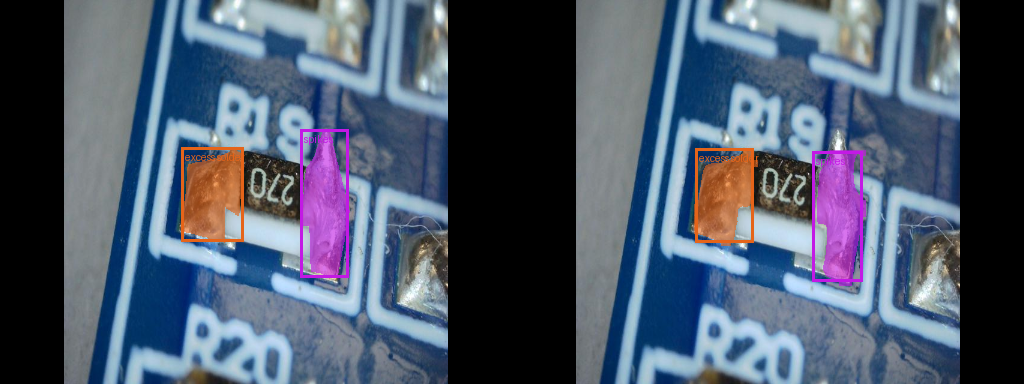

In [15]:
from IPython.display import Image
Image(filename='infer_results_defects_model/PrecisionSegmentBBoxHead_InstanceSegmentationVisualizer_1.png')

<a name ="export-and-archive"></a>

## 🗂️ Export and Archive

Once the model is trained and tested, we want to prepare it for deployment on the device. This preparation consists of 2 steps. First, we want to export the model trained with PyTorch to a more general format called [`Open Neural Network Exchange (ONNX)`](https://onnx.ai/). Then, we want to package this exported model with all the metadata containing information about the inputs, outputs, and training configuration used. This is called archiving. These steps can be done quickly with just one command in `LuxonisTrain`.

In [ ]:
archieve_path = luxonis_model.archive(weights=weights)
print("Model archieved to:", archieve_path)

Notice that two new folders were created in our run directory. One is called `export` and has an ONNX model while the other is called `archive` which has `.tar.xz` file. The tar file is a compressed file that holds the aforementioned ONNX model with all the model metadata.

To use the NN archive for conversion, please copy the path to the .tar.xz file:

In [ ]:
NN_ARCHIVE_PATH = "<YOUR_MODEL_ARCHIVE_PATH>"

<a name ="deploy"></a>

## 🤖 Deploy

Now that we have successfully exported and archived the model, we aim to deploy it to the Luxonis device. The model's specific format depends on the Luxonis device series you have. We will show you how to use our [`ModelConverter`](https://github.com/luxonis/modelconverter) to convert the model as simply as possible. 

We'll start by installing the `ModelConverter`.

In [ ]:
%pip install -q modelconv==0.4.2 -U

We will use the `ModelConverter` Python API, which leverages our [`HubAI`](https://hub.luxonis.com) platform to perform model conversion in the background. To get started, you'll need to create an account on `HubAI` and obtain your team’s API key.

In [ ]:
HUBAI_API_KEY = "<YOUR_HUBAI_API_KEY>"

Model conversion can be done via either the CLI or the Python API — here, we'll use the latter. For more information, see the [online usage section](https://github.com/luxonis/modelconverter?tab=readme-ov-file#online-usage) of the documentation.

The call below creates a new model card within your team on `HubAI`, uploads the model file and metadata, then performs cloud-side conversion to the selected target platform (e.g., [`RVC2`](https://rvc4.docs.luxonis.com/hardware/platform/rvc/rvc2/), [`RVC4`](https://rvc4.docs.luxonis.com/hardware/platform/rvc/rvc4/)). Once completed, the converted model is automatically downloaded to your device.

For HubAI-specific conversion parameters, refer to the [online conversion section](https://github.com/luxonis/modelconverter/tree/e6a3478ba47d8f92d4d60217f2aee0f4f468cb14/modelconverter/hub#online-conversion) of the ModelConverter documentation. Platform-specific parameters are also documented there.


In [ ]:
from modelconverter import convert

converted_model = convert.RVC4(
    api_key=HUBAI_API_KEY,
    path=NN_ARCHIVE_PATH,
    name="PCB Defect Instance Segmentation1",
    description_short="PCB Defect Instance Segmentation Model",
    tasks=["INSTANCE_SEGMENTATION"],
    license_type="MIT",
    is_public=False
)

We have successfully converted our trained model for an RVC4 device, so let's test it! Please copy the path to the downloaded archive with the converted model from the output log of the last code cell; we will use it in the next section.

In [ ]:
MODEL_PATH = "<YOUR_DOWNLOADED_MODEL_ARCHIVE_PATH>"

<a name ="depthai-script"></a>

## 📷 DepthAI Script

To test our model on one of our cameras, we first need to install [`DepthAI`](https://rvc4.docs.luxonis.com/software/) in version 3 and [`DepthAI Nodes`](https://rvc4.docs.luxonis.com/software/ai-inference/depthai-nodes/). Moreover, the script we'll write must run locally and require a Luxonis device connected to your machine.

In [ ]:
%pip install -q depthai==3.0.0rc2 -U
%pip install -q depthai-nodes==0.3.0 -U

To run the model on a DepthAI device using the script below, please note the following:

- You can view the output stream by opening [http://localhost:8082](http://localhost:8082) in your browser.

- If you're running the script from a Jupyter Notebook, the output may not appear directly within the notebook. The script should print a link pointing to [http://localhost:8082](http://localhost:8082) for accessing the stream.

- To stop the video stream, press **`q`** while focused on the visualizer page.

In [ ]:
DEVICE = None # Set to None to use the default device, or you can specify a specific device IP

In [ ]:
import depthai as dai
from depthai_nodes.node import ParsingNeuralNetwork, ApplyColormap, ImgFrameOverlay

device = dai.Device(dai.DeviceInfo(DEVICE)) if DEVICE else dai.Device()
platform = device.getPlatform()
img_frame_type = dai.ImgFrame.Type.BGR888i if platform.name == "RVC4" else dai.ImgFrame.Type.BGR888p
visualizer = dai.RemoteConnection(httpPort=8082)

with dai.Pipeline(device) as pipeline:
    cam = pipeline.create(dai.node.Camera).build()
    nn_archive = dai.NNArchive(MODEL_PATH)
    # Create the neural network node
    nn_with_parser = pipeline.create(ParsingNeuralNetwork).build(
        cam.requestOutput((640, 640), type=img_frame_type, fps=30), 
        nn_archive
    )
    # transform output array to colormap
    apply_colormap_node = pipeline.create(ApplyColormap).build(nn_with_parser.out)
    # overlay frames
    overlay_frames_node = pipeline.create(ImgFrameOverlay).build(
        nn_with_parser.passthrough,
        apply_colormap_node.out,
    ) 
    # Configure the visualizer node
    visualizer.addTopic("Video", overlay_frames_node.out, "images")
    visualizer.addTopic("Detections", nn_with_parser.out, "detections")

    pipeline.start()
    visualizer.registerPipeline(pipeline)

    while pipeline.isRunning():
        key = visualizer.waitKey(1)
        if key == ord("q"):
            print("Got q key from the remote connection!")
            break

Yay! 🎉🎉🎉 Huge congratulations, you have successfully finished this tutorial in which you deployed an instance segmentation model trained using `luxonis-train` on a PCB defects dataset to our camera!